In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import icarusplot
from VariableInfoMap import defaultVarInfoMap

@@ Importing mplstyle from /home/jskim/lib/icarusplot//icarus_style.mplstyle


In [2]:
# Hmm, icarusplot uses font.sans-serif but giving error on EAF.. ad-hoc fix
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]

# USER from environment variable

In [3]:
USER = os.environ['USER']
print('USER:', USER)

USER: jskim


# Working directory

In [4]:
# Put the path of GUNDAMWorkshopSept2025 repo. Assuming you are at home directory
WD = f'/home/{USER}/GUNDAMWorkshopSept2025'
print('WD:', WD)

WD: /home/jskim/GUNDAMWorkshopSept2025


# Plot directory

In [5]:
PlotBaseDir = f'{WD}/plots'
os.system(f'mkdir -p {PlotBaseDir}')
print('PlotBaseDir:',PlotBaseDir)

PlotBaseDir: /home/jskim/GUNDAMWorkshopSept2025/plots


# NUISANCE Tree Input base directory
Assuming a structure of:
```
{NuisBaseDir}/{GeneratorName}/{GeneratorConfigName}/{FluxType}/{GeneratorJobName}/Target_{TargetName}/Nu_-14/output_gen_0.root
```
for example,
```
/exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar/fhc_Nu14/output_GENIE_0.nuisflat.root
```

In [6]:
NuisBaseDir = '/exp/icarus/data/users/jskim/Generators'

In [7]:
# Type (or name) of the flux
FluxType = 'ICARUS_NuMI'
# FluxType = 'ICARUS_BNB'

HornCur= 'fhc'

In [8]:
TargetName = 'Ar'
NNucleon = 40

# True if you want xsec/nucleon 
# False if you want xsec/Ar
DoPerNucleon = False

# CAFMode to NUISANCEMode mapping

In [9]:
NuisanceModeMap = dict()
NuisanceModeMap['QE'] = {'CAFMode': 0, 'Modes': [1, 51, 52], 'Latex': 'QE'}
NuisanceModeMap['MEC'] = {'CAFMode': 10, 'Modes': [2], 'Latex': 'MEC'}
# Mode=10 in GiBBU seems like to be a RES mode..
NuisanceModeMap['RES'] = {'CAFMode': 1, 'Modes': [17, 38, 39, 11, 12, 13, 22, 42, 43, 23, 44, 45, 21, 41, 10], 'Latex': 'RES'}
NuisanceModeMap['COH'] = {'CAFMode': 3, 'Modes': [16, 36], 'Latex': 'COH'}
NuisanceModeMap['DIS'] = {'CAFMode': 2, 'Modes': [26, 46], 'Latex': 'DIS'}

In [10]:
# List of fluxes
# If you are doing numu-only BNB, comment out numubar

NuTypes = [
    'numu',
    'numubar',
]

NuAliases = [
    r'\nu_{\mu}',
    r'\bar{\nu}_{\mu}',
]


In [11]:
# - GeneratorFluxBinWidthDivided
#   - Prepare<Generator> application from nuisance saves flux into the sample
#   - True if the flux you gave to the generator was divided by the bin width

GeneratorName = 'GENIE'
GeneratorConfigName = 'AR23_20i_00_000'
GeneratorJobName = 'GUNDAMWorkshopSept2025'
GeneratorFluxBinWidthDivided = True # False for my BNB example sample

# GeneratorName = 'NuWro'
# GeneratorConfigName = '21.09.2'
# GeneratorJobName = 'GUNDAMWorkshopSept2025'
# GeneratorFluxBinWidthDivided = False

# GeneratorName = 'GiBUU'
# GeneratorConfigName = 'r2025_02'
# # GeneratorJobName = '250617_GiBUU_Try0'
# GeneratorJobName = '250728_GiBUU_MoreStatsFromEAF'
# GeneratorFluxBinWidthDivided = True

# GeneratorName = 'NEUT'
# # GeneratorConfigName = '5.8.0'
# # GeneratorJobName = '250625_NEUT_1M'
# GeneratorConfigName = '6.0.3'
# # GeneratorJobName = '250807_QE_rome'
# # GeneratorJobName = '250807_QE_rmf'
# # GeneratorJobName = '250807_QE_nieves'
# GeneratorJobName = '250807_QE_ls'
# GeneratorFluxBinWidthDivided = True

In [12]:
# plot directory
PlotDir = f'{PlotBaseDir}/{GeneratorName}/{GeneratorConfigName}/{GeneratorJobName}'
os.system(f'mkdir -p {PlotDir}')

0

# NUISANCE flat tree

In [13]:
# I will evaluate the flux expression into this variable and use it later
# So DO NOT change this
NuisTreeSFVarName = 'FinalWeight'

# Weights to convert event rate to cross-section
# If you want a reweighted distribution, use "Weight" instead of "InputWeight"
# The reweight is configured when running nuisflat via nuisance card
NuisTreeSFVarExpr = 'InputWeight * fScaleFactor'

In [14]:
NuisBranches = [
    'Mode',
    'Enu_true',
    'InputWeight',
    'RWWeight',
    'Weight',
    'fScaleFactor',
    'MLep',
    'ELep',
    
    'ICARUS_1muNp0pi_IsSignal',
    'ICARUS_1muNp0pi_MuonCos',
    'ICARUS_1muNp0pi_MuonProtonCos',
    'ICARUS_1muNp0pi_deltaPT',
    'ICARUS_1muNp0pi_deltaalphaT',
    
    'ICARUS_1mu2p0pi_IsSignal',
    'ICARUS_1mu2p0pi_HadronicOpeningAngle',
    'ICARUS_1mu2p0pi_MuonHadronAngle',
    'ICARUS_1mu2p0pi_DeltaPT',
    'ICARUS_1mu2p0pi_DeltaAlphaT',
    'ICARUS_1mu2p0pi_DeltaPhiT',
    'ICARUS_1mu2p0pi_DeltaPTT',
    
    'ICARUS_1mu1pi0_IsSignal',
    'ICARUS_1mu1pi0_MuonP',
    'ICARUS_1mu1pi0_NeutralPionP',
]

In [15]:
# DO NOT FIX THIS
NuisTreeName = 'FlatTree_VARS'

In [16]:
# Nuisance input base director is made out of variables defined above
NuisFlatTreeBaseDir = f'{NuisBaseDir}/{GeneratorName}/{GeneratorConfigName}/{FluxType}/{GeneratorJobName}/Target_{TargetName}/' #/Nu_-14/output_gen_0.root'

In [17]:
# Read and save nuisflat trees here

# key = 'numu' or 'numubar'
# - dataframe converted from nuisflat tree
dfs_nuis = dict()
# - uproot histogram of fluxes
uhs_input_flux = dict()
# - Number of files 
#  - E.g., if you have generated multiple events and adding them,
#          you need to divide the histogram by the number of files,
#          otherwise the cross-section will be multiplied by Number of files!
dict_NFiles = dict()
# - Flux integral
dict_FluxIntegral = dict()

# Loop over flux nu types
for NuType in NuTypes:

    print(NuType)

    NuPDG = 14 if NuType == 'numu' else -14

    # Expected file name format; wildcard is supported
    nuisflat_wc = f'{NuisFlatTreeBaseDir}/{HornCur}_Nu{NuPDG}/output_{GeneratorName}_*.nuisflat.root'
    print(nuisflat_wc)
    # Get the list of files that matches the pattern
    nuisflat_files = glob.glob(nuisflat_wc)

    # Initialize the dictionaries
    dfs_nuis[NuType] = None
    dict_NFiles[NuType] = len(nuisflat_files)

    print(dict_NFiles[NuType])

    # Loop over matched files
    for nuisflat_file in nuisflat_files:

        with uproot.open(nuisflat_file) as f:

            print('  :', nuisflat_file)

            this_df = f[NuisTreeName].arrays(NuisBranches, library='pd')
            this_input_flux = f['FlatTree_FLUX']

            if dfs_nuis[NuType] is None:
                dfs_nuis[NuType] = this_df

                if GeneratorFluxBinWidthDivided:
                    FluxBinning = this_input_flux.to_numpy()[1]
                    FluxBinWidhts = np.diff(FluxBinning)
                    FluxIntegral = np.sum( np.multiply(this_input_flux.to_numpy()[0], FluxBinWidhts) )
                else:
                    FluxIntegral = np.sum( this_input_flux.to_numpy()[0] )


                # Let's make flux /cm2
                if GeneratorName == 'GiBUU':
                    # I gave GiBUU /cm2
                    FluxIntegral *= 1
                else:
                    FluxIntegral *= 1E-4

                dict_FluxIntegral[NuType] = FluxIntegral
                print('Flux integral, '+NuType+':', FluxIntegral)


            else:
                dfs_nuis[NuType] = pd.concat([dfs_nuis[NuType], this_df])

            del this_df

    # Weight
    dfs_nuis[NuType] = dfs_nuis[NuType].eval(f'{NuisTreeSFVarName} = {NuisTreeSFVarExpr}')

    # Special
    # 1) Converting Enu to GeV
    dfs_nuis[NuType]['Enu_true'] = dfs_nuis[NuType]['Enu_true'] * 1E-3

    # 2) Calculating lepton momentum out of energy and mass
    dfs_nuis[NuType]['PLep'] = np.sqrt( dfs_nuis[NuType]['ELep']**2 - dfs_nuis[NuType]['MLep']**2 )
    dfs_nuis[NuType]['PLep'] = dfs_nuis[NuType]['PLep'] * 1E-3

    # Modes
    conditions = []
    values = []
    for NuisanceModeName in NuisanceModeMap:
        ThisCAFMode = NuisanceModeMap[NuisanceModeName]['CAFMode']
        ThisModeArray = NuisanceModeMap[NuisanceModeName]['Modes']
        
        conditions.append(np.abs(dfs_nuis[NuType]['Mode']).isin(ThisModeArray))
        values.append(ThisCAFMode)
    dfs_nuis[NuType]['CAFMode'] = np.select(conditions, values, default=-1)



numu
/exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_*.nuisflat.root
10
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_8.nuisflat.root
Flux integral, numu: 4.616344683953715e-10
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_2.nuisflat.root
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_0.nuisflat.root
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_4.nuisflat.root
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/GUNDAMWorkshopSept2025/Target_Ar//fhc_Nu14/output_GENIE_1.nuisflat.root
  : /exp/icarus/data/users/jskim/Generators/GENIE/AR2

# Signal selection using nuisflat variables

In [18]:
# 1) ICARUS NuMI 1muNp0pi
NuisTree_SignalSelection_Expr = '(ICARUS_1muNp0pi_IsSignal==True)'

# 2) ICARUS NuMI 1mu(N>1)p0pi
# NuisTree_SignalSelection_Expr = '(ICARUS_1mu2p0pi_IsSignal==True)'

# 3) ICARUS BNB 1mu1pi0
# NuisTree_SignalSelection_Expr = '(ICARUS_1mu1pi0_IsSignal==True)'

# CAF TruthTree

## If you give the CAF TruthVar Tree which includes your signal events, you can directly compare them to the nuisance calculation
## For that, we need the normalization parameters
- Flux integral will be found from the nuisflat tree
- Number of targets; in this script, give the number of Argon. Then depending on `DoPerNucleon`, it will divide the cross section by number of nucleons of not

In [19]:
# 1) Typical ICARUS FV
# - 25cm margin in x and y
# - 30 (50)cm upstream (downstream) in z
#NTarget = 4.714056E+30

# 2) ICARUS NuMI 1muNp0pi has bad-region rejection
# - FV above
# - Field cage filuare in TPC EE: reject (-358.49<x<-210.215) and (y>115 or y<-161.86)
# - Dangling cable in TPC WW: reject (210.215<x<358.49) and (z>0) and (y>70)
NTarget = 4.6079073E+30

In [20]:
# I will evaluate the flux expression into this variable and use it later
# So DO NOT change this
CAFCVWeightName = 'CAFCVWeight'

# 1) ICARUS NuMI 1muNp0pi
CAFFileBaseDir = '/exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/250627_BadRegionRejection/CAFTree'
CAFFileName = 'MakeTree_NuMI_MC_Nu_Phase2_2023ANuMIReproc_CAFTypeCommonRemerge_ReNuSyst250403_WithTrackSplit_BNBFixedProb.root'
CAFTreeName = 'AllSamples_FillTree/trueEvents'
CAFFluxWeightExpr = 'FluxWeightWithBeamWidthCorrection'
CAFBranches = [
    'FluxWeightWithBeamWidthCorrection',
    'TruePDG',
    'TrueMode',
    'TrueMuonP',
    'TrueMuonCos',
    'TrueMuonProtonCos',
    'TruedeltaPT',
    'TruedeltaalphaT',
    'TrueE',
    'TrueNProton',
]
CAFENuName = 'TrueE'
CAFNuPDGName = 'TruePDG'
CAFSignalSelectionExpr = '' # empty if your Signal tree already has signal def cut
CAFPOTHistName = 'AllSamples_FillTree/POT'

# 3) ICARUS BNB 1mu1pi0
# CAFFileBaseDir = '/exp/icarus/app/users/lkashur/medulla/medulla/gundam'
# CAFFileName = 'signal_syst_gundaminput.root'
# CAFTreeName = 'signal'
# CAFFluxWeightExpr = '1.6193e+19'
# CAFBranches = [
#     'true_neutrino_energy',
#     'true_pdg',
#     'true_pi0_momentum',
#     'category_topology_ccpi0_simple2',
# ]
# CAFENuName = 'true_neutrino_energy'
# CAFNuPDGName = 'true_pdg'
# CAFSignalSelectionExpr = 'category_topology_ccpi0_simple2==0'
# CAFPOTHistName = ''
# CAFMCPOT = 1.5012648193073904e+21 # I added this to scale Lane's CAF to match the input flux file



In [21]:
with uproot.open(f'{CAFFileBaseDir}/{CAFFileName}') as f:
    df_CAF = f[CAFTreeName].arrays(CAFBranches, library='pd')

    if CAFSignalSelectionExpr!='':
        df_CAF = df_CAF.query(CAFSignalSelectionExpr)
    
    if CAFPOTHistName!='':
        MCPOT = f[CAFPOTHistName].to_numpy()[0][0]
    else:
        MCPOT = CAFMCPOT

    # CAF CV weight
    df_CAF = df_CAF.eval(f'{CAFCVWeightName} = {CAFFluxWeightExpr}') 

In [22]:
print('MCPOT:', MCPOT)

MCPOT: 1.0900766313859168e+21


# Comparing the neutrino energy distribution between CAF and nuisance

## If CAF and nuisance are made with the same Generator configuration (i.e., same GENIE tune), this is a good thing to check if the flux used between CAF and nuisance tree are comparable

numu 2821805
numubar 994492


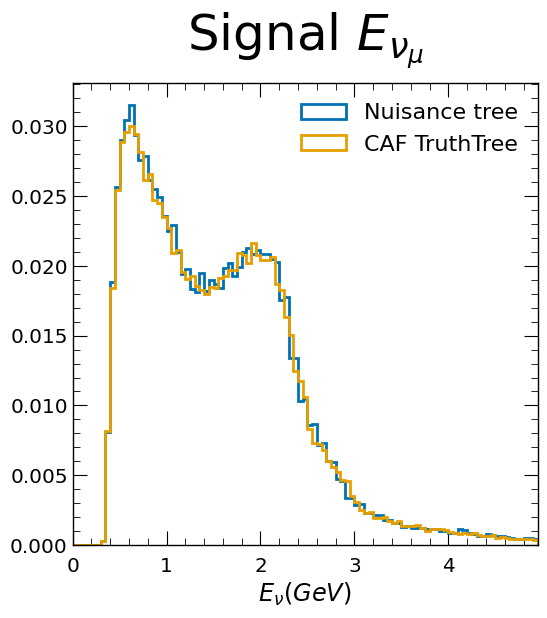

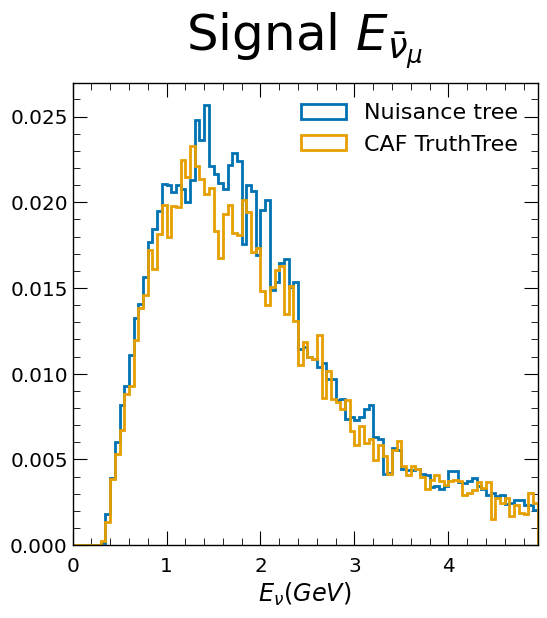

In [23]:
SignalAreas_nuis = dict()
SignalAreas_CAF = dict()

ThisNuisVariableName = 'Enu_true'
ThisCAFVariableName = CAFENuName
ThisBinning = np.linspace(0., 6., 120+1)
ThisBinning = ThisBinning[ThisBinning<5.0]
ThisXaxisTitle = r'$E_{\nu} (GeV)$'

for i_NuType, NuType in enumerate(NuTypes):

    NuLatex = NuAliases[i_NuType]
    
    # Nuisance Tree

    df_nuis_Sel = dfs_nuis[NuType].query(NuisTree_SignalSelection_Expr)

    print(NuType, len(df_nuis_Sel))

    h_nuis = np.histogram(
        df_nuis_Sel[ThisNuisVariableName],
        bins=ThisBinning,
        weights=df_nuis_Sel[NuisTreeSFVarName],
    )[0]
    area_nuis = np.sum(h_nuis)

    SignalAreas_nuis[NuType] = area_nuis

    del df_nuis_Sel

    # CAFTree

    NuPDG = 14 if NuType=='numu' else -14
    df_CAF_Sel = df_CAF.query(f'({CAFNuPDGName}=={NuPDG})')

    h_CAF = np.histogram(
        df_CAF_Sel[ThisCAFVariableName],
        bins=ThisBinning,
        weights=df_CAF_Sel[CAFCVWeightName],
    )[0]
    area_CAF = np.sum(df_CAF_Sel[CAFCVWeightName])

    SignalAreas_CAF[NuType] = area_CAF

    del df_CAF_Sel

    # plot

    fig, ax = plt.subplots(figsize=(6,6))

    ax.hist(
        ThisBinning[:-1], 
        bins=ThisBinning,
        weights=h_nuis/area_nuis,
        histtype='step',
        label='Nuisance tree',
    )

    ax.hist(
        ThisBinning[:-1], 
        bins=ThisBinning,
        weights=h_CAF/area_CAF,
        histtype='step',
        label='CAF TruthTree',
    )

    ax.set_xlim(left=ThisBinning[0], right=ThisBinning[-1])
    ax.set_xlabel(ThisXaxisTitle)
    ax.set_title('Signal '+r'$E_{%s}$'%(NuLatex))

    ax.legend(fontsize=16)

    fig.savefig(f'{PlotDir}/Signal_NuE_{NuType}.pdf', bbox_inches='tight')


# Now, give the information of variables you want to calculate differential cross sections

In [24]:
VariableInfos = []

# (VariableName, Branch name in nuisflat, Branch name in CAF TruthTree, xMin, xMax, dx) 
# - (xMin, xMax, dx) is for the "FineBin" version
# - The "analysis binning" is defined in the "VariableInfoMap.py"
#   - They can be variable-width binning

# 1) ICARUS NuMI 1muNp0pi
VariableInfos.append([
    'TrueMuonCos',
    'ICARUS_1muNp0pi_MuonCos',
    'TrueMuonCos',
    -1, 1, 0.05
])
# VariableInfos.append([
#     'TrueMuonProtonCos',
#     'ICARUS_1muNp0pi_MuonProtonCos',
#     'TrueMuonProtonCos',
#     -1, 1, 0.1
# ])
# VariableInfos.append([
#     'TruedeltaPT',
#     'ICARUS_1muNp0pi_deltaPT',
#     'TruedeltaPT',
#     0, 1.2, 0.02 if GeneratorName=='GiBUU' else 0.01
# ])
# VariableInfos.append([
#     'TruedeltaalphaT',
#     'ICARUS_1muNp0pi_deltaalphaT',
#     'TruedeltaalphaT',
#     0, 180, 6 if GeneratorName=='GiBUU' else 5
# ])

# 2) ICARUS NuMI 1mu(N>1)p0pi
# VariableInfos = []
# VariableInfos.append([
#     'DeltaPTT',
#     'ICARUS_1mu2p0pi_DeltaPTT',
#     '',
#     -1, 1, 0.1 if GeneratorName=='GiBUU' else 0.1
# ])

# 3) ICARUS BNB 1mu1pi0
# VariableInfos = []
# VariableInfos.append([
#     'NeutralPionP',
#     'ICARUS_1mu1pi0_NeutralPionP',
#     'true_pi0_momentum',
#     0, 1.2, 0.05
# ])

In [25]:
PhaseSpaceCutInfos = [
    ['AllSignal', 'All signal events', '', ''],
    # ['MuonPLT0p8', r'$p_{\mu}<0.8$', 'TrueMuonP<0.8', 'PLep<0.8'],
]

- VariableName: TrueMuonCos
  - PhaseSpaceCutName: AllSignal
     - UseFineBinning: True
       - TotalIntegral: 3.089e-38
     - UseFineBinning: False
       - TotalIntegral: 3.089e-38


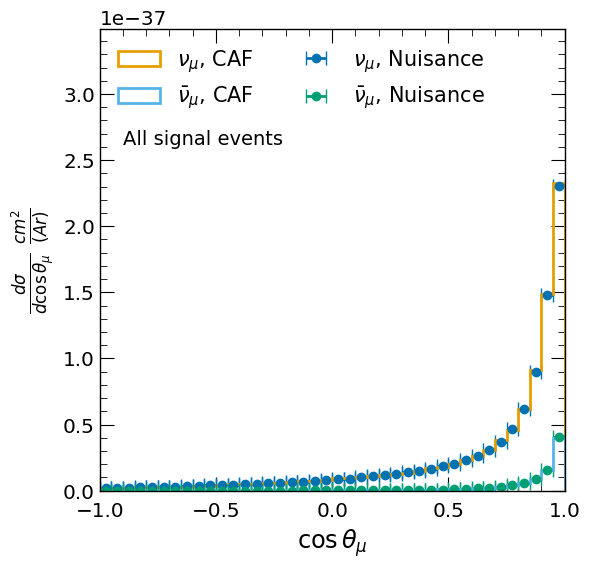

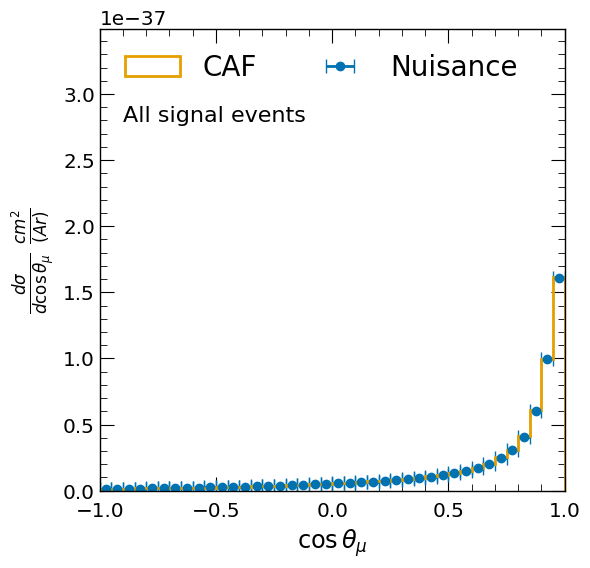

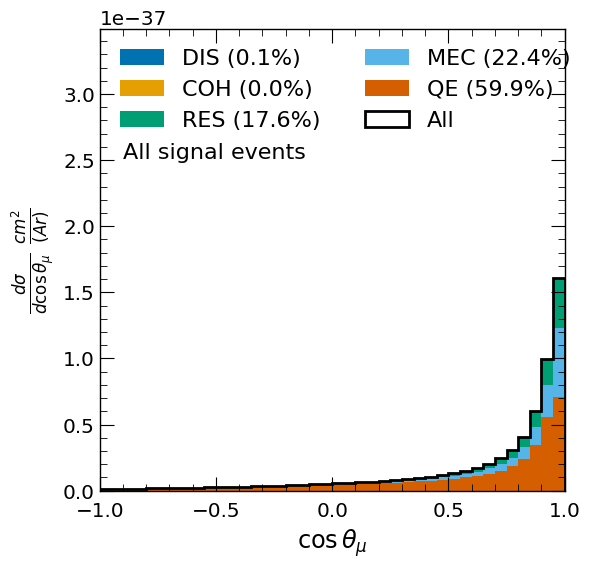

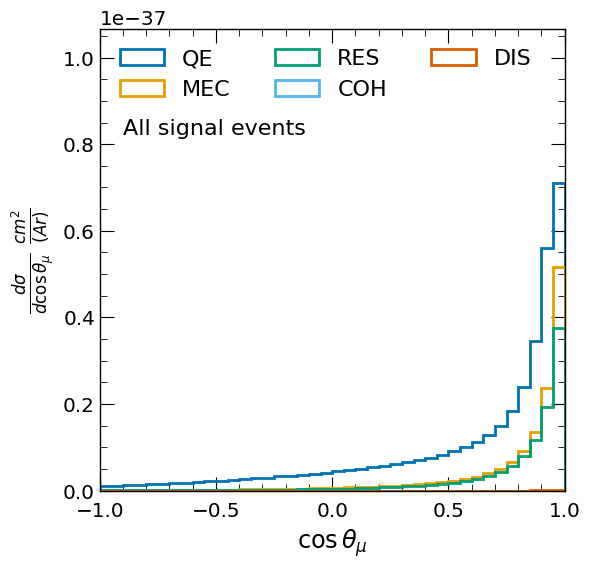

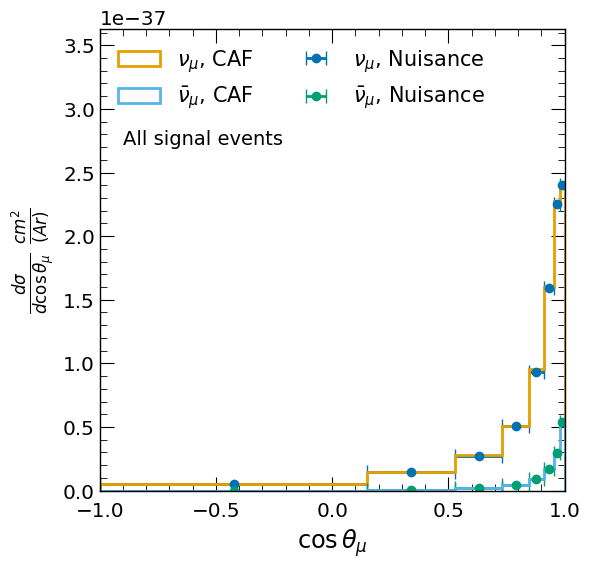

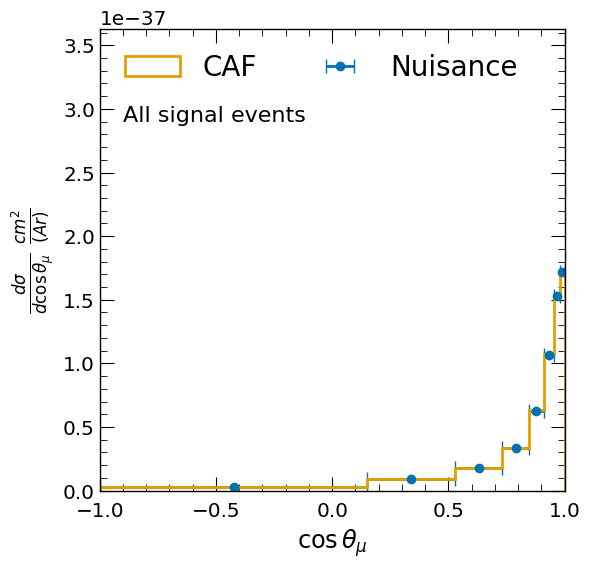

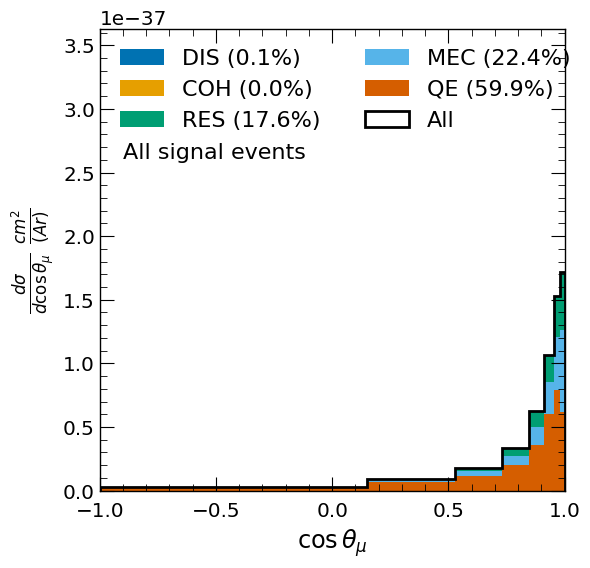

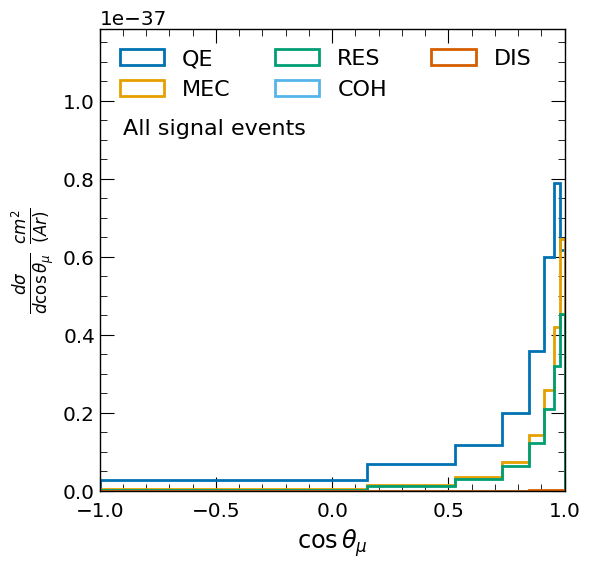

In [26]:
for VariableInfo in VariableInfos:

    VariableName = VariableInfo[0]
    NuisVariableName = VariableInfo[1]
    CAFVariableName = VariableInfo[2]
    FineBin_xMin = VariableInfo[3]
    FineBin_xMax = VariableInfo[4]
    FineBin_dx = VariableInfo[5]

    VariableInfo = defaultVarInfoMap[VariableName]
    VariableLatex = r'$%s$'%(VariableInfo.Latex)

    DoCAF = (CAFVariableName!='')
    
    print(f'- VariableName: {VariableName}')
    
    XsecLatex = r'$\frac{d \sigma}{d %s}$ $\frac{cm^{2}}{%s(%s)}$'%(
        VariableInfo.Latex,
        '' if VariableInfo.Unit=='' else '(%s)'%(VariableInfo.Unit),
        'nucleon' if DoPerNucleon else TargetName
    )
    
    for PhaseSpaceCutInfo in PhaseSpaceCutInfos:

        PhaseSpaceCutName = PhaseSpaceCutInfo[0]
        PhaseSpaceCutLatex = PhaseSpaceCutInfo[1]
        PhaseSpaceCutExpr_CAF = PhaseSpaceCutInfo[2]
        PhaseSpaceCutExpr_Nuis = PhaseSpaceCutInfo[3]

        ApplyPhaseSpaceCut = (PhaseSpaceCutName!='AllSignal')

        print(f'  - PhaseSpaceCutName: {PhaseSpaceCutName}')

        for UseFineBinning in [True, False]:
            
            Binnings = np.linspace(FineBin_xMin, FineBin_xMax, int((FineBin_xMax-FineBin_xMin)/FineBin_dx)+1) \
                if UseFineBinning  else VariableInfo.GetBinArray()
            BinWidhts = np.diff(Binnings)
            BinCenters = [(Binnings[i]+Binnings[i+1])/2. for i in range(len(Binnings)-1)]
            BinErrors = [(Binnings[i+1]-Binnings[i])/2. for i in range(0, len(Binnings)-1)]

            BinningString = 'FineBin' if UseFineBinning else 'AnaBin'

            print(f'     - UseFineBinning: {UseFineBinning}')

            #-------------------------------------------
            # numu vs numubar

            fig_diffxsec, ax_diffxsec = plt.subplots(figsize=(6,6))

            hs_diffxsec = dict()
            hs_diffxsec_mode = dict()
            hs_CAFxsec = dict()

            y_max = -1
            for i_NuType, NuType in enumerate(NuTypes):
                
                NuPDG = 14 if NuType=='numu' else -14
                FluxIntegral = dict_FluxIntegral[NuType]

                NFiles = dict_NFiles[NuType]
                NEvent = len(dfs_nuis[NuType])

                df_nuis_Sel = dfs_nuis[NuType].query(NuisTree_SignalSelection_Expr)
                df_CAF_Sel = df_CAF.query(f'({CAFNuPDGName}=={NuPDG})')

                if ApplyPhaseSpaceCut:
                    df_nuis_Sel = df_nuis_Sel.query(PhaseSpaceCutExpr_Nuis)
                    df_CAF_Sel = df_CAF_Sel.query(PhaseSpaceCutExpr_CAF)

                h_diffxsec = np.histogram(
                    df_nuis_Sel[NuisVariableName],
                    bins=Binnings,
                    weights=df_nuis_Sel[NuisTreeSFVarName],
                )[0]

                hs_diffxsec[NuType] = h_diffxsec/BinWidhts/NFiles * NNucleon
                if DoPerNucleon:
                    hs_diffxsec[NuType] /= NNucleon
                
                ax_diffxsec.errorbar(
                    BinCenters, 
                    hs_diffxsec[NuType],
                    xerr=BinErrors, 
                    fmt='o', 
                    capsize=5,
                    label=r'$%s$, Nuisance'%(NuAliases[i_NuType]),
                )

                y_max = max(y_max, np.max(hs_diffxsec[NuType]))

                # per mode
                hs_diffxsec_mode[NuType] = dict()
                for NuisanceModeName in NuisanceModeMap:
                    ThisCAFMode = NuisanceModeMap[NuisanceModeName]['CAFMode']

                    df_nuis_Sel_mode = df_nuis_Sel.query(f'CAFMode=={ThisCAFMode}')
                    h_diffxsec_mode = np.histogram(
                        df_nuis_Sel_mode[NuisVariableName],
                        bins=Binnings,
                        weights=df_nuis_Sel_mode[NuisTreeSFVarName],
                    )[0]
                    hs_diffxsec_mode[NuType][ThisCAFMode] = h_diffxsec_mode/BinWidhts/NFiles * NNucleon
                    if DoPerNucleon:
                        hs_diffxsec_mode[NuType][ThisCAFMode] /= NNucleon

                if DoCAF:
                    # CAFTree
                    hs_CAFxsec[NuType] = np.histogram(
                        df_CAF_Sel[CAFVariableName],
                        bins=Binnings,
                        weights=df_CAF_Sel[CAFCVWeightName] / NTarget / np.sum(FluxIntegral * MCPOT),
                    )[0]
                    hs_CAFxsec[NuType] /= BinWidhts
                    if DoPerNucleon:
                        hs_CAFxsec[NuType] /= NNucleon
    
                    ax_diffxsec.hist(
                        Binnings[:-1], 
                        bins=Binnings,
                        weights=hs_CAFxsec[NuType],
                        histtype='step',
                        label=r'$%s$, CAF'%(NuAliases[i_NuType]),
                    )
    
                    y_max = max(y_max, np.max(hs_CAFxsec[NuType]))


            ax_diffxsec.set_xlim(Binnings[0], Binnings[-1])
            ax_diffxsec.set_xlabel(VariableLatex)
            ax_diffxsec.set_ylim(0, 1.5*y_max)
            ax_diffxsec.set_ylabel(XsecLatex)

            ax_diffxsec.legend(loc='upper left', fontsize=15, ncols=2)

            _xrange = ax_diffxsec.get_xlim()
            _use_x = _xrange[0] + 0.05*(_xrange[1] - _xrange[0])
            _yrange = ax_diffxsec.get_ylim()
            _use_y = _yrange[0] + 0.75*(_yrange[1] - _yrange[0])
            ax_diffxsec.text(_use_x, _use_y, PhaseSpaceCutLatex, fontsize=14)

            OutName = f'{PlotDir}/diffxsec_{PhaseSpaceCutName}_bothnu_{VariableName}_{BinningString}.pdf'

            fig_diffxsec.savefig(OutName, bbox_inches='tight')
            # plt.close()

            #-------------------------------------------
            # numu+numubar flux-averaged

            fig_diffxsec, ax_diffxsec = plt.subplots(figsize=(6,6))

            h_diffxsec_sum = np.zeros(len(Binnings)-1)
            h_CAFxsec_sum = np.zeros(len(Binnings)-1)

            FluxSum = 0.

            # hs_diffxsec_mode

            for i_NuType, NuType in enumerate(NuTypes):
                
                FluxIntegral = dict_FluxIntegral[NuType]
                FluxSum += FluxIntegral

                h_diffxsec_sum += hs_diffxsec[NuType] * FluxIntegral
                if DoCAF:
                    h_CAFxsec_sum += hs_CAFxsec[NuType] * FluxIntegral


            h_diffxsec_sum /= FluxSum
            if DoCAF:
                h_CAFxsec_sum /= FluxSum

            ax_diffxsec.errorbar(
                BinCenters, 
                h_diffxsec_sum,
                xerr=BinErrors, 
                fmt='o', 
                capsize=5,
                label='Nuisance'
            )
            
            if DoCAF:
                ax_diffxsec.hist(
                    Binnings[:-1], 
                    bins=Binnings,
                    weights=h_CAFxsec_sum,
                    histtype='step',
                    label='CAF',
                )

            ax_diffxsec.set_xlim(Binnings[0], Binnings[-1])
            ax_diffxsec.set_xlabel(VariableLatex)
            ax_diffxsec.set_ylim(0, 1.5*y_max)
            ax_diffxsec.set_ylabel(XsecLatex)

            _xrange = ax_diffxsec.get_xlim()
            _use_x = _xrange[0] + 0.05*(_xrange[1] - _xrange[0])
            _yrange = ax_diffxsec.get_ylim()
            _use_y = _yrange[0] + 0.80*(_yrange[1] - _yrange[0])
            ax_diffxsec.text(_use_x, _use_y, PhaseSpaceCutLatex, fontsize=16)

            ax_diffxsec.legend(loc='upper left', fontsize=20, ncols=2)

            OutName = f'{PlotDir}/diffxsec_{PhaseSpaceCutName}_fluxavg_{VariableName}_{BinningString}.pdf'

            fig_diffxsec.savefig(OutName, bbox_inches='tight')

            fig_diffxsec, ax_diffxsec = plt.subplots(figsize=(6,6))
            # plt.close()

            #-------------------------------------------
            # numu+numubar flux-averaged mode break-down, stacked

            hists = []
            h_diffxsec_sum_mode = dict()
            tmp_ModeNames = []
            for NuisanceModeName in NuisanceModeMap:
                ThisCAFMode = NuisanceModeMap[NuisanceModeName]['CAFMode']
                ThisLatex = NuisanceModeMap[NuisanceModeName]['Latex']

                h_diffxsec_sum_mode[ThisCAFMode] = np.zeros(len(Binnings)-1)

                for i_NuType, NuType in enumerate(NuTypes):
                    
                    FluxIntegral = dict_FluxIntegral[NuType]

                    h_diffxsec_sum_mode[ThisCAFMode] += hs_diffxsec_mode[NuType][ThisCAFMode] * FluxIntegral

                h_diffxsec_sum_mode[ThisCAFMode] /= FluxSum

                tmp_ModeNames.append(NuisanceModeName)
                hists.append( h_diffxsec_sum_mode[ThisCAFMode] )

            stackhists = [
                np.sum( np.array( hists[:(len(hists)-i)] ), axis=0) for i in range(len(hists))
            ]

            TotalIntegral = np.sum(h_diffxsec_sum * BinWidhts)
            print('       - TotalIntegral: %1.3e'%(TotalIntegral))

            for i_s in range(len(NuisanceModeMap)):

                j_s = len(NuisanceModeMap)-1-i_s
                NuisanceModeName = tmp_ModeNames[j_s]
                ThisLatex = NuisanceModeMap[NuisanceModeName]['Latex']

                ThisArea = np.sum(hists[j_s] * BinWidhts)
                Frac = ThisArea/TotalIntegral

                ax_diffxsec.hist(
                    Binnings[:-1], 
                    bins=Binnings,
                    weights=stackhists[i_s],
                    # color=SampleColor,
                    label=f'{ThisLatex}'+' (%1.1f%%)'%(100.*Frac),
                )

            ax_diffxsec.hist(
                Binnings[:-1], 
                bins=Binnings,
                weights=h_diffxsec_sum,
                color='k',
                label='All',
                histtype='step',
            )

            ax_diffxsec.set_xlim(Binnings[0], Binnings[-1])
            ax_diffxsec.set_xlabel(VariableLatex)
            ax_diffxsec.set_ylim(0, 1.5*y_max)
            ax_diffxsec.set_ylabel(XsecLatex)

            _xrange = ax_diffxsec.get_xlim()
            _use_x = _xrange[0] + 0.05*(_xrange[1] - _xrange[0])
            _yrange = ax_diffxsec.get_ylim()
            _use_y = _yrange[0] + 0.72*(_yrange[1] - _yrange[0])
            ax_diffxsec.text(_use_x, _use_y, PhaseSpaceCutLatex, fontsize=16)

            ax_diffxsec.legend(loc='upper left', fontsize=16, ncols=2)

            OutName = f'{PlotDir}/diffxsec_{PhaseSpaceCutName}_fluxavg_breakdown_{VariableName}_{BinningString}.pdf'

            fig_diffxsec.savefig(OutName, bbox_inches='tight')
            # plt.close()

            #-------------------------------------------
            # numu+numubar flux-averaged mode break-down, shape

            fig_diffxsec, ax_diffxsec = plt.subplots(figsize=(6,6))

            y_max = -1
            for i_s in range(len(NuisanceModeMap)):

                NuisanceModeName = tmp_ModeNames[i_s]
                ThisLatex = NuisanceModeMap[NuisanceModeName]['Latex']

                ThisArea = np.sum( hists[i_s] * BinWidhts )

                ax_diffxsec.hist(
                    Binnings[:-1], 
                    bins=Binnings,
                    weights=hists[i_s],
                    # color=SampleColor,
                    label=f'{ThisLatex}',
                    histtype='step',
                )

                y_max = max(y_max, np.max(hists[i_s]))

            ax_diffxsec.set_xlim(Binnings[0], Binnings[-1])
            ax_diffxsec.set_xlabel(VariableLatex)
            ax_diffxsec.set_ylim(0, 1.5*y_max)
            ax_diffxsec.set_ylabel(XsecLatex)

            _xrange = ax_diffxsec.get_xlim()
            _use_x = _xrange[0] + 0.05*(_xrange[1] - _xrange[0])
            _yrange = ax_diffxsec.get_ylim()
            _use_y = _yrange[0] + 0.77*(_yrange[1] - _yrange[0])
            ax_diffxsec.text(_use_x, _use_y, PhaseSpaceCutLatex, fontsize=16)

            ax_diffxsec.legend(loc='upper left', fontsize=16, ncols=3)

            OutName = f'{PlotDir}/diffxsec_{PhaseSpaceCutName}_fluxavg_permode_{VariableName}_{BinningString}.pdf'
            fig_diffxsec.savefig(OutName, bbox_inches='tight')
            # plt.close()

            #-------------------------------------------
            # csv output

            output = {
                'x_center': BinCenters,
                'x_err': BinErrors,
                'xsec': h_diffxsec_sum
            }
            for NuisanceModeName in NuisanceModeMap:
                ThisCAFMode = NuisanceModeMap[NuisanceModeName]['CAFMode']
                this_col_name = f'xsec_{NuisanceModeName}'
                output[this_col_name] = h_diffxsec_sum_mode[ThisCAFMode]

            df_xsec = pd.DataFrame(output)

            os.system(f'mkdir -p {WD}/xsecs')

            OutCSVName = f'{WD}/xsecs/xsec_{PhaseSpaceCutName}_{GeneratorName}_{GeneratorConfigName}_{GeneratorJobName}_{VariableName}_{BinningString}.csv'

            df_xsec.to_csv(OutCSVName, index=False)

